In [1]:
import os
import glob
import numpy as np
import pandas as pd
import SimpleITK as sitk
from skimage import transform, measure
import random
import tqdm

# Configuration
data_path = "kaggle/input/luna-16/Dataset"
subset_paths = [os.path.join(data_path, f"subset{i}/subset{i}") for i in range(10)]
segmentation_path = os.path.join(data_path, "seg-lungs-LUNA16/seg-lungs-LUNA16")
annotations_file = os.path.join(data_path, "annotations.csv")
preproc_scan_dir = "kaggle/working/preprocessed_scans"
preproc_mask_dir = "kaggle/working/preprocessed_masks"

PATCH_SIZE = 48
POSITIVE_PATCH_RATIO = 0.8

# Load and preprocess annotations
annotations = pd.read_csv(
    annotations_file,
    names=["seriesuid", "coordX", "coordY", "coordZ", "diameter_mm"],
    header=None
)
for col in ["coordX", "coordY", "coordZ", "diameter_mm"]:
    annotations[col] = pd.to_numeric(annotations[col], errors='coerce')
annotations = annotations.dropna()
nodule_annotations = annotations.drop_duplicates()

def load_ct_scan(seriesuid):
    for subset_path in subset_paths:
        mhd_path = os.path.join(subset_path, f"{seriesuid}.mhd")
        if os.path.exists(mhd_path):
            ct_itk = sitk.ReadImage(mhd_path)
            ct_scan = sitk.GetArrayFromImage(ct_itk).astype(np.float32)
            origin = np.array(list(reversed(ct_itk.GetOrigin())))
            spacing = np.array(list(reversed(ct_itk.GetSpacing())))
            return ct_scan, origin, spacing
    print(f"Could not find CT scan for {seriesuid}")
    return None, None, None

def load_lung_mask(seriesuid):
    mask_path = os.path.join(segmentation_path, f"{seriesuid}.mhd")
    if os.path.exists(mask_path):
        mask_itk = sitk.ReadImage(mask_path)
        mask = sitk.GetArrayFromImage(mask_itk)
        return mask
    else:
        return None

os.makedirs(preproc_scan_dir, exist_ok=True)
os.makedirs(preproc_mask_dir, exist_ok=True)

all_seriesuids = []
for subset_path in subset_paths:
    mhd_files = glob.glob(os.path.join(subset_path, "*.mhd"))
    all_seriesuids.extend([os.path.basename(f).replace(".mhd", "") for f in mhd_files])
all_seriesuids = list(set(all_seriesuids))
print(f"Total scans (including negative): {len(all_seriesuids)}")
print(f"Using {len(all_seriesuids)} scans for training and validation.")

def process_scan(seriesuid):
    ct_scan, origin, spacing = load_ct_scan(seriesuid)
    if ct_scan is None:
        return None, None
    target_spacing = [2.0, 2.0, 2.0]
    resize_factor = np.array(spacing) / np.array(target_spacing)
    new_shape = np.round(ct_scan.shape * resize_factor).astype(int)
    ct_scan = transform.resize(
        ct_scan,
        new_shape,
        order=1,
        mode='constant',
        cval=-1000,
        anti_aliasing=True
    )
    lung_mask = load_lung_mask(seriesuid)
    if lung_mask is not None:
        lung_mask = transform.resize(
            lung_mask.astype(np.float32),
            new_shape,
            order=0,
            mode='constant',
            preserve_range=True,
            anti_aliasing=False
        )
        lung_mask = (lung_mask > 0.5).astype(np.uint8)
        ct_scan[lung_mask == 0] = -1000
    ct_scan = np.clip(ct_scan, -1000, 400)
    ct_scan = (ct_scan + 1000) / 1400
    mask = np.zeros(ct_scan.shape, dtype=np.float32)
    scan_annotations = nodule_annotations[nodule_annotations["seriesuid"] == seriesuid]
    for _, annotation in scan_annotations.iterrows():
        world_coord = np.array([annotation["coordX"], annotation["coordY"], annotation["coordZ"]])
        voxel_coord = np.round((world_coord - origin) / spacing).astype(int)
        processed_coord = np.round(voxel_coord * resize_factor).astype(int)
        processed_coord = np.clip(processed_coord, 0, np.array(ct_scan.shape) - 1)
        radius = max(2, int(annotation["diameter_mm"] / 2))
        z, y, x = np.ogrid[:ct_scan.shape[0], :ct_scan.shape[1], :ct_scan.shape[2]]
        distance = np.sqrt((z - processed_coord[0])**2 +
                           (y - processed_coord[1])**2 +
                           (x - processed_coord[2])**2)
        mask[distance <= radius] = 1.0
    return ct_scan, mask

# Only precompute scans/masks (as before; this part is unchanged)
scans_done = [os.path.exists(os.path.join(preproc_scan_dir, f"{uid}.npz")) for uid in all_seriesuids]
masks_done = [os.path.exists(os.path.join(preproc_mask_dir, f"{uid}.npz")) for uid in all_seriesuids]
if all(scans_done) and all(masks_done):
    print("All precomputed scans/masks found. Skipping scan/mask precompute phase.")
else:
    print("Precomputing and saving scans/masks...")
    for i, seriesuid in enumerate(all_seriesuids):
        scan_out = os.path.join(preproc_scan_dir, f"{seriesuid}.npz")
        mask_out = os.path.join(preproc_mask_dir, f"{seriesuid}.npz")
        if os.path.exists(scan_out) and os.path.exists(mask_out):
            continue
        ct_scan, mask = process_scan(seriesuid)
        if ct_scan is not None:
            np.savez_compressed(scan_out, ct_scan.astype(np.float16))
            np.savez_compressed(mask_out, mask.astype(np.uint8))
        else:
            print(f"Skipping {seriesuid} (could not process)")
        if i % 20 == 0:
            print(f"Processed {i+1}/{len(all_seriesuids)} scans...")
    print("Scan/mask precompute phase done.")

# The rest will be handled in the data generator for training!

Total scans (including negative): 888
Using 888 scans for training and validation.
All precomputed scans/masks found. Skipping scan/mask precompute phase.


2025-04-24 06:05:55.236259: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 06:05:55.243804: I external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:469] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
I0000 00:00:1745471155.252169  153801 cuda_dnn.cc:8703] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
I0000 00:00:1745471155.254836  153801 cuda_blas.cc:1413] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745471155.261800  153801 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[INFO] Mixed precision enabled.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


I0000 00:00:1745471158.532588  153801 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0


[TRAIN] Starting fit


/home/ved/School/4DS/Data Science Project/code/notebooks/.direnv/python-3.10.17/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-04-24 06:06:01.300703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-04-24 06:06:01.300753: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/50


2025-04-24 06:06:03.633257: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1745471164.237590  153942 cuda_dnn.cc:529] Loaded cuDNN version 90800


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9519 - dice_coefficient: 0.0087 - loss: 1.3934INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-04-24 06:08:28.771108: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 1: val_dice_coefficient improved from -inf to 0.01576, saving model to best_patch_model.keras


2025-04-24 06:09:15.336310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 194s 376ms/step - accuracy: 0.9520 - dice_coefficient: 0.0087 - loss: 1.3933 - val_accuracy: 0.9922 - val_dice_coefficient: 0.0158 - val_loss: 1.2585 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9949 - dice_coefficient: 0.0095 - loss: 1.2292
Epoch 2: val_dice_coefficient improved from 0.01576 to 0.02138, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 175s 350ms/step - accuracy: 0.9949 - dice_coefficient: 0.0095 - loss: 1.2292 - val_accuracy: 0.9916 - val_dice_coefficient: 0.0214 - val_loss: 1.1923 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9936 - dice_coefficient: 0.0159 - loss: 1.1648

2025-04-24 06:14:23.653488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 3: val_dice_coefficient improved from 0.02138 to 0.03470, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 175s 349ms/step - accuracy: 0.9936 - dice_coefficient: 0.0159 - loss: 1.1648 - val_accuracy: 0.9927 - val_dice_coefficient: 0.0347 - val_loss: 1.1219 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9899 - dice_coefficient: 0.0238 - loss: 1.1134
Epoch 4: val_dice_coefficient improved from 0.03470 to 0.05438, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 179s 358ms/step - accuracy: 0.9899 - dice_coefficient: 0.0238 - loss: 1.1133 - val_accuracy: 0.9822 - val_dice_coefficient: 0.0544 - val_loss: 1.0705 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9886 - dice_coefficient: 0.0421 - loss: 1.0646
Epoch 5: val_dice_coefficient did not improve from 0.05438
500/500 ━━━━━━━━━━━━━━━━━━━━ 177s 354ms/step - accuracy: 0.9886 - dice_coefficient: 0.0421

2025-04-24 06:21:01.072695: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9894 - dice_coefficient: 0.0534 - loss: 1.0275
Epoch 6: val_dice_coefficient improved from 0.05438 to 0.10474, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 174s 348ms/step - accuracy: 0.9894 - dice_coefficient: 0.0534 - loss: 1.0275 - val_accuracy: 0.9705 - val_dice_coefficient: 0.1047 - val_loss: 1.0044 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9889 - dice_coefficient: 0.0804 - loss: 0.9822
Epoch 7: val_dice_coefficient improved from 0.10474 to 0.10949, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 175s 350ms/step - accuracy: 0.9889 - dice_coefficient: 0.0804 - loss: 0.9822 - val_accuracy: 0.9906 - val_dice_coefficient: 0.1095 - val_loss: 0.9451 - learning_rate: 1.0000e-04
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9908 - dice_coefficient: 0.1168 - loss: 0.9296
Epoch 8: val_dice_coefficient improved from 0.

2025-04-24 06:37:41.325290: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 11: val_dice_coefficient did not improve from 0.22867
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 342ms/step - accuracy: 0.9943 - dice_coefficient: 0.2711 - loss: 0.7525 - val_accuracy: 0.9928 - val_dice_coefficient: 0.2139 - val_loss: 0.8219 - learning_rate: 1.0000e-04
Epoch 12/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9951 - dice_coefficient: 0.3410 - loss: 0.6800
Epoch 12: val_dice_coefficient did not improve from 0.22867
500/500 ━━━━━━━━━━━━━━━━━━━━ 173s 347ms/step - accuracy: 0.9951 - dice_coefficient: 0.3410 - loss: 0.6800 - val_accuracy: 0.9920 - val_dice_coefficient: 0.2250 - val_loss: 0.8199 - learning_rate: 1.0000e-04
Epoch 13/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9956 - dice_coefficient: 0.3868 - loss: 0.6328
Epoch 13: val_dice_coefficient improved from 0.22867 to 0.33934, saving model to best_patch_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 170s 340ms/step - accuracy: 0.9956 - dice_coefficient: 0.3868 - loss: 0.6328 - val_accuracy: 0.9909 

2025-04-24 07:07:02.796940: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9974 - dice_coefficient: 0.5764 - loss: 0.4384
Epoch 22: val_dice_coefficient did not improve from 0.33934
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 341ms/step - accuracy: 0.9974 - dice_coefficient: 0.5764 - loss: 0.4385 - val_accuracy: 0.9930 - val_dice_coefficient: 0.2397 - val_loss: 0.8189 - learning_rate: 1.0000e-04
Epoch 23/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9974 - dice_coefficient: 0.5862 - loss: 0.4290
Epoch 23: val_dice_coefficient did not improve from 0.33934

Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 172s 344ms/step - accuracy: 0.9974 - dice_coefficient: 0.5862 - loss: 0.4290 - val_accuracy: 0.9920 - val_dice_coefficient: 0.1296 - val_loss: 0.9390 - learning_rate: 1.0000e-04
[TRAIN] Finished training in 4006.75s


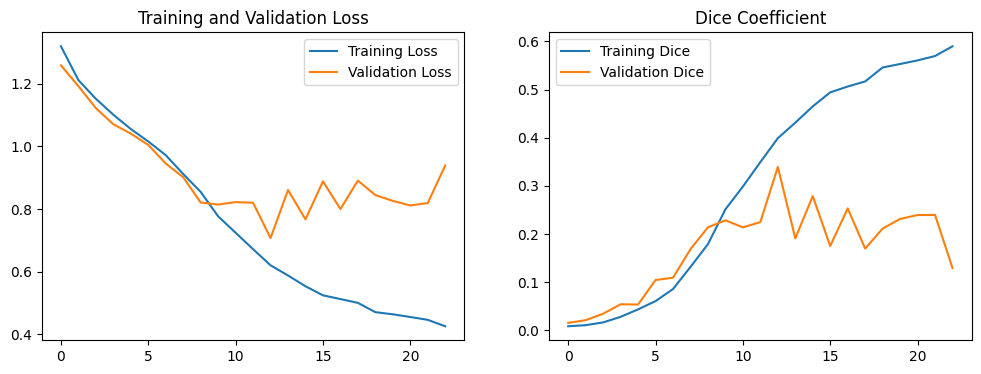


Processing scan 1: 1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378


2025-04-24 07:12:51.066090: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Detected 1 nodules. Dice: 0.0189
Nodule 1: Centroid=(97, 22, 22), Diameter=3.8mm, Confidence=0.78


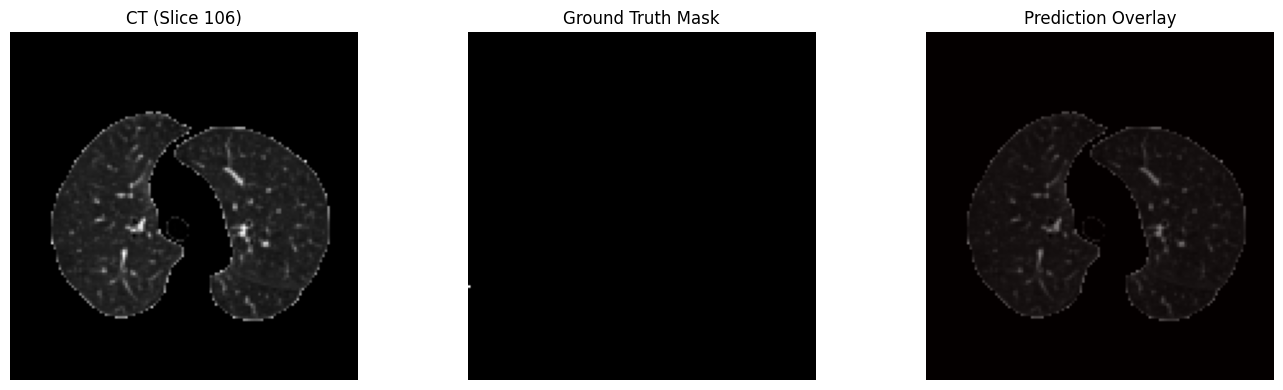

Saved visualization to val_scan_1_overlay.png

Processing scan 2: 1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281


2025-04-24 07:13:02.116246: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Detected 0 nodules. Dice: 0.0033


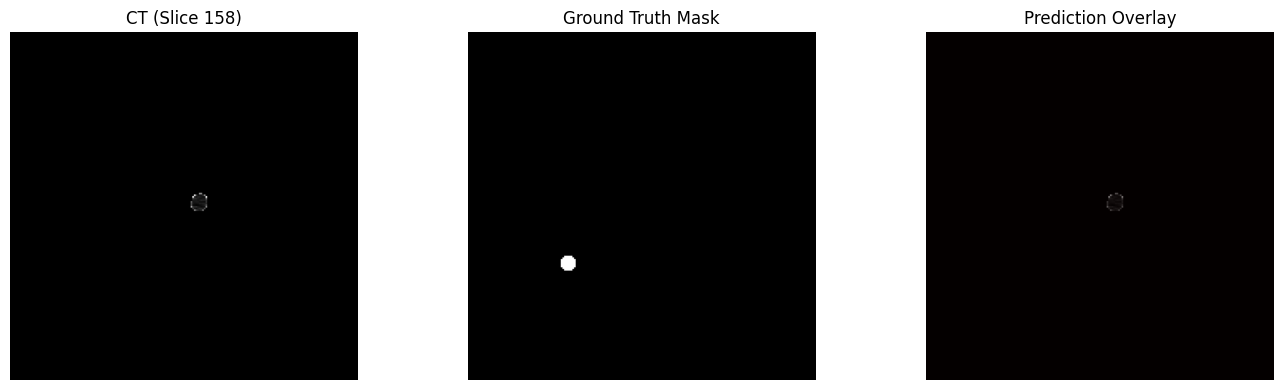

Saved visualization to val_scan_2_overlay.png

Processing scan 3: 1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464


2025-04-24 07:13:24.015388: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


Detected 0 nodules. Dice: 0.0127


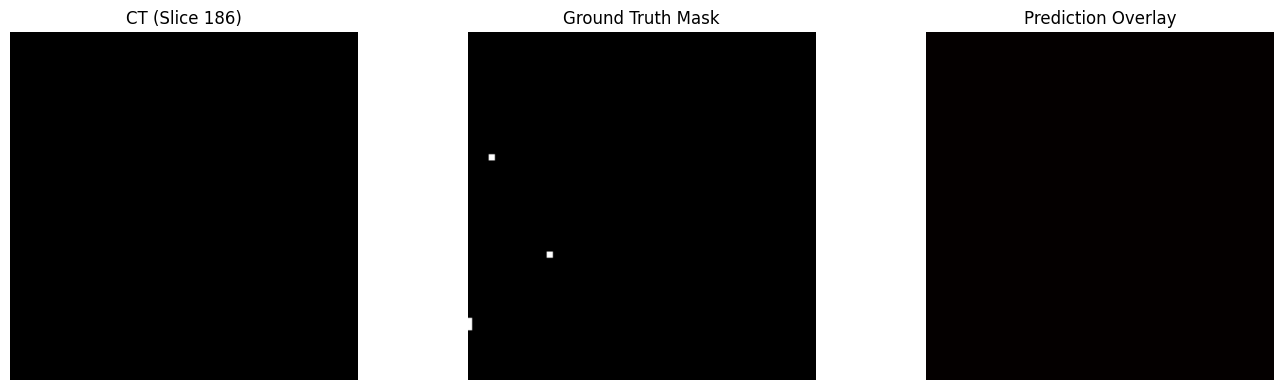

Saved visualization to val_scan_3_overlay.png


In [2]:
import os
import numpy as np
import tensorflow as tf
from skimage import measure, morphology
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, UpSampling3D,
                                     concatenate, BatchNormalization, Activation,
                                     SpatialDropout3D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time

# --- Mixed precision for speed, only if GPU present ---
physical_gpus = tf.config.list_physical_devices('GPU')
if len(physical_gpus) > 0:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print("[INFO] Mixed precision enabled.")
    except Exception as e:
        print("[INFO] Mixed precision not enabled:", e)
else:
    print("[INFO] No GPU found. Mixed precision NOT enabled.")

print(tf.config.list_physical_devices('GPU'))

# --- Configuration ---
PATCH_SIZE = 48
BATCH_SIZE = 12
EPOCHS = 50
INITIAL_LR = 1e-4
VAL_SAMPLES = 3  # Number of scans to visualize/test on
ON_THE_FLY_PATCHES_PER_EPOCH = 6000  # Number of patches per epoch; adjust for speed/memory

PREPROC_SCAN_DIR = "kaggle/working/preprocessed_scans"
PREPROC_MASK_DIR = "kaggle/working/preprocessed_masks"

# --- Dice ---
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def dice_coef_np(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten().astype(np.float32)
    y_pred_f = y_pred.flatten().astype(np.float32)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# --- On-the-fly Patch Data Generator ---
class OnTheFlyPatchGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, seriesuids, preproc_scan_dir, preproc_mask_dir,
        patch_size, batch_size, patches_per_epoch,
        positive_ratio=0.95, augment_fn=None, shuffle=True
    ):
        self.seriesuids = list(seriesuids)
        self.scan_dir = preproc_scan_dir
        self.mask_dir = preproc_mask_dir
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.patches_per_epoch = (patches_per_epoch // batch_size) * batch_size
        self.positive_ratio = positive_ratio
        self.augment_fn = augment_fn
        self.shuffle = shuffle
        self.on_epoch_end()
        self._scan_cache = {}
        self._mask_cache = {}

    def __len__(self):
        return self.patches_per_epoch // self.batch_size

    def __getitem__(self, idx):
        X, Y = [], []
        n_positive = 0
        at_least = max(3, int(0.4 * self.batch_size))  # at least 3-5 positives per batch
        collected = 0
        # First, force enough positives
        while n_positive < at_least and collected < self.batch_size:
            sid = random.choice(self.seriesuids)
            scan, mask = self._load_scan_mask(sid)
            if scan is None or mask is None or not np.any(mask > 0):
                continue
            coords = np.argwhere(mask > 0)
            if len(coords) == 0:
                continue
            z, y, x = coords[random.randint(0, len(coords) - 1)]
            z1, y1, x1 = z - self.patch_size // 2, y - self.patch_size // 2, x - self.patch_size // 2
            z2, y2, x2 = z1 + self.patch_size, y1 + self.patch_size, x1 + self.patch_size
            patch = scan[z1:z2, y1:y2, x1:x2]
            patch_mask = mask[z1:z2, y1:y2, x1:x2]
            if patch.shape == (self.patch_size, self.patch_size, self.patch_size):
                if self.augment_fn:
                    patch, patch_mask = self.augment_fn(patch, patch_mask)
                X.append(patch[..., np.newaxis])
                Y.append(patch_mask[..., np.newaxis])
                n_positive += 1
                collected += 1
        # Fill the rest with normal sampling
        while collected < self.batch_size:
            sid = random.choice(self.seriesuids)
            scan, mask = self._load_scan_mask(sid)
            if scan is None or mask is None:
                continue
            if np.any(mask > 0) and random.random() < self.positive_ratio:
                coords = np.argwhere(mask > 0)
                if len(coords) == 0:
                    continue
                z, y, x = coords[random.randint(0, len(coords) - 1)]
            else:
                try:
                    z = random.randint(self.patch_size // 2, scan.shape[0] - self.patch_size // 2 - 1)
                    y = random.randint(self.patch_size // 2, scan.shape[1] - self.patch_size // 2 - 1)
                    x = random.randint(self.patch_size // 2, scan.shape[2] - self.patch_size // 2 - 1)
                except ValueError:
                    continue
            z1, y1, x1 = z - self.patch_size // 2, y - self.patch_size // 2, x - self.patch_size // 2
            z2, y2, x2 = z1 + self.patch_size, y1 + self.patch_size, x1 + self.patch_size
            patch = scan[z1:z2, y1:y2, x1:x2]
            patch_mask = mask[z1:z2, y1:y2, x1:x2]
            if patch.shape == (self.patch_size, self.patch_size, self.patch_size):
                if self.augment_fn:
                    patch, patch_mask = self.augment_fn(patch, patch_mask)
                X.append(patch[..., np.newaxis])
                Y.append(patch_mask[..., np.newaxis])
                collected += 1
        X = np.array(X, dtype=np.float32)
        Y = np.array(Y, dtype=np.float32)
        return X, Y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.seriesuids)

    def _load_scan_mask(self, sid):
        if sid not in self._scan_cache:
            try:
                scan = np.load(os.path.join(self.scan_dir, f"{sid}.npz"))['arr_0']
                self._scan_cache[sid] = scan
            except:
                self._scan_cache[sid] = None
        if sid not in self._mask_cache:
            try:
                mask = np.load(os.path.join(self.mask_dir, f"{sid}.npz"))['arr_0']
                self._mask_cache[sid] = mask
            except:
                self._mask_cache[sid] = None
        return self._scan_cache[sid], self._mask_cache[sid]

# --- Patch Augmentation ---
def augment_patch(patch, mask):
    for axis in range(3):
        if random.random() < 0.5:
            patch = np.flip(patch, axis=axis)
            mask = np.flip(mask, axis=axis)
    k = random.randint(0, 3)
    patch = np.rot90(patch, k, axes=(1, 2))
    mask = np.rot90(mask, k, axes=(1, 2))
    if random.random() < 0.3:
        factor = 0.9 + 0.2 * random.random()
        patch = patch * factor
    if random.random() < 0.3:
        noise = np.random.normal(0, 0.03, patch.shape)
        patch = patch + noise
    patch = np.clip(patch, 0, 1)
    return patch, mask

# --- Model ---
def build_patch_unet(input_shape):
    inputs = Input(input_shape)
    conv1 = Conv3D(16, (3, 3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv3D(16, (3, 3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    pool1 = SpatialDropout3D(0.1)(pool1)
    conv2 = Conv3D(32, (3, 3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv3D(32, (3, 3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    pool2 = SpatialDropout3D(0.1)(pool2)
    conv3 = Conv3D(64, (3, 3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv3D(64, (3, 3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    pool3 = SpatialDropout3D(0.2)(pool3)
    conv4 = Conv3D(128, (3, 3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv3D(128, (3, 3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    up5 = UpSampling3D((2, 2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv3D(64, (3, 3, 3), padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv3D(64, (3, 3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    up6 = UpSampling3D((2, 2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv3D(32, (3, 3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv3D(32, (3, 3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    up7 = UpSampling3D((2, 2, 2))(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv3D(16, (3, 3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(16, (3, 3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    outputs = Conv3D(1, (1, 1, 1), activation='sigmoid', dtype='float32')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- Full Scan Loader (for validation visualization) ---
def load_precomputed_scan(seriesuid):
    ct_scan = np.load(os.path.join(PREPROC_SCAN_DIR, f"{seriesuid}.npz"))['arr_0']
    mask = np.load(os.path.join(PREPROC_MASK_DIR, f"{seriesuid}.npz"))['arr_0']
    return ct_scan, mask

# --- Full Scan Prediction (for visualization only) ---
def predict_full_scan(model, seriesuid, patch_size=PATCH_SIZE, stride=24, threshold=0.5):
    ct_scan, mask = load_precomputed_scan(seriesuid)
    if ct_scan is None:
        return None, None, None
    depth, height, width = ct_scan.shape
    output = np.zeros(ct_scan.shape, dtype=np.float32)
    counts = np.zeros(ct_scan.shape, dtype=np.float32)
    z_steps = range(patch_size//2, depth - patch_size//2, stride)
    y_steps = range(patch_size//2, height - patch_size//2, stride)
    x_steps = range(patch_size//2, width - patch_size//2, stride)
    for z in z_steps:
        for y in y_steps:
            for x in x_steps:
                patch = ct_scan[
                    z-patch_size//2:z+patch_size//2,
                    y-patch_size//2:y+patch_size//2,
                    x-patch_size//2:x+patch_size//2
                ]
                if patch.shape != (patch_size, patch_size, patch_size):
                    continue
                pred = model.predict(
                    np.expand_dims(np.expand_dims(patch, 0), -1),
                    verbose=0
                )[0, ..., 0]
                output[
                    z-patch_size//2:z+patch_size//2,
                    y-patch_size//2:y+patch_size//2,
                    x-patch_size//2:x+patch_size//2
                ] += pred
                counts[
                    z-patch_size//2:z+patch_size//2,
                    y-patch_size//2:y+patch_size//2,
                    x-patch_size//2:x+patch_size//2
                ] += 1
    output = output / (counts + 1e-6)
    binary_mask = (output > threshold).astype(np.uint8)
    binary_mask = morphology.remove_small_objects(binary_mask.astype(bool), min_size=27)
    binary_mask = morphology.remove_small_holes(binary_mask, area_threshold=27)
    binary_mask = binary_mask.astype(np.uint8)
    nodules = []
    labeled_mask = measure.label(binary_mask)
    regions = measure.regionprops(labeled_mask, intensity_image=output)
    for region in regions:
        z, y, x = region.centroid
        diameter = 2 * (region.area * 3 / (4 * np.pi)) ** (1/3)
        nodules.append({
            'centroid': (int(x), int(y), int(z)),
            'diameter': diameter,
            'score': region.mean_intensity,
            'bbox': region.bbox
        })
    return nodules, output, binary_mask

# --- Visualization ---
def visualize_prediction(ct_scan, gt_mask, pred_mask, slice_idx=None, save_path=None):
    if slice_idx is None:
        # Try to find a slice with any nodule in GT or prediction
        nonzero_slices = np.where(np.sum(gt_mask, axis=(1, 2)) + np.sum(pred_mask, axis=(1, 2)) > 0)[0]
        if len(nonzero_slices) > 0:
            slice_idx = int(nonzero_slices[len(nonzero_slices)//2])
        else:
            slice_idx = ct_scan.shape[0] // 2
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(ct_scan[slice_idx], cmap="gray")
    plt.title(f"CT (Slice {slice_idx})")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask[slice_idx], cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(ct_scan[slice_idx], cmap="gray")
    plt.imshow(pred_mask[slice_idx], cmap="hot", alpha=0.5)
    plt.title("Prediction Overlay")
    plt.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# --- Main ---
if __name__ == "__main__":
    all_seriesuids = [
        os.path.splitext(f)[0]
        for f in os.listdir(PREPROC_SCAN_DIR) if f.endswith(".npz")
    ]
    # Filter for scans with any positive mask voxels for validation visualization
    good_val_uids = []
    for uid in all_seriesuids:
        msk = np.load(os.path.join(PREPROC_MASK_DIR, f"{uid}.npz"))['arr_0']
        if np.sum(msk) > 0:
            good_val_uids.append(uid)
    train_uids, val_uids = train_test_split(all_seriesuids, test_size=0.2, random_state=42)
    val_uids = [uid for uid in val_uids if uid in good_val_uids]
    if len(val_uids) < VAL_SAMPLES:
        val_uids = good_val_uids[:VAL_SAMPLES]

    train_patches = (ON_THE_FLY_PATCHES_PER_EPOCH // BATCH_SIZE) * BATCH_SIZE
    val_patches = (min(ON_THE_FLY_PATCHES_PER_EPOCH // 4, 1200) // BATCH_SIZE) * BATCH_SIZE

    train_gen = OnTheFlyPatchGenerator(
        train_uids,
        preproc_scan_dir=PREPROC_SCAN_DIR,
        preproc_mask_dir=PREPROC_MASK_DIR,
        patch_size=PATCH_SIZE,
        batch_size=BATCH_SIZE,
        patches_per_epoch=train_patches,
        positive_ratio=0.95,
        augment_fn=augment_patch,
        shuffle=True
    )
    val_gen = OnTheFlyPatchGenerator(
        val_uids,
        preproc_scan_dir=PREPROC_SCAN_DIR,
        preproc_mask_dir=PREPROC_MASK_DIR,
        patch_size=PATCH_SIZE,
        batch_size=BATCH_SIZE,
        patches_per_epoch=val_patches,
        positive_ratio=0.95,
        augment_fn=None,  # Don't augment val
        shuffle=True
    )

    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = build_patch_unet((PATCH_SIZE, PATCH_SIZE, PATCH_SIZE, 1))
        model.compile(
            optimizer=Adam(learning_rate=INITIAL_LR),
            loss=bce_dice_loss,
            metrics=['accuracy', dice_coefficient]
        )
    callbacks = [
        ModelCheckpoint(
            'best_patch_model.keras',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_dice_coefficient',
            patience=10,
            mode='max',
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_dice_coefficient',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            mode='max',
            verbose=1
        ),
        CSVLogger('training_log.csv')
    ]
    print("[TRAIN] Starting fit")
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    print(f"[TRAIN] Finished training in {time.time() - start_time:.2f}s")

    # --- Plot loss and Dice curves ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.legend()
    plt.savefig("loss_dice_curves.png")
    plt.show()

    # --- Evaluate and visualize on a few validation scans (with nodules) ---
    for i, seriesuid in enumerate(val_uids[:VAL_SAMPLES]):
        print(f"\nProcessing scan {i+1}: {seriesuid}")
        nodules, pred_prob, pred_mask = predict_full_scan(model, seriesuid)
        ct_scan, gt_mask = load_precomputed_scan(seriesuid)
        dice = dice_coef_np(gt_mask, pred_mask)
        print(f"Detected {len(nodules)} nodules. Dice: {dice:.4f}")
        for j, nodule in enumerate(nodules, 1):
            print(f"Nodule {j}: Centroid={nodule['centroid']}, "
                  f"Diameter={nodule['diameter']:.1f}mm, "
                  f"Confidence={nodule['score']:.2f}")
        if ct_scan is not None and pred_mask is not None:
            img_path = f"val_scan_{i+1}_overlay.png"
            visualize_prediction(ct_scan, gt_mask, pred_mask, save_path=img_path)
            print(f"Saved visualization to {img_path}")